## Extract subject ROI estimates per condition and plot by group

bhanji@psychology.rutgers.edu
<br>April 29, 2021

In [1]:
# load packages and set study specific variables
import os
import pandas as pd

#glm results path info
results_topdir = "/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask" #study results directory 
taskname = "cardtask"
feat_dir_format = "sub-%s/preproc2_basicnoaroma/basicnoaroma_run-01.feat" #"sub-%s/basicmodel/run-01.feat" #later filled w/ sub (no leading "/")
feat_stats_dir_format = "sub-%s/preproc2_basicnoaroma/basicnoaroma_run-01.feat/stats" #later filled w/ sub (no leading "/")

#group, subject info
# group_list = ["opiod","control"]
# subject_groups = { 
#     "opiod": ['601','602','603','604','605','606','607','608','609','610','611','612','613','614',
#                '615','616','617','618','620'], #after each groupname include participant labels list
#     "control": ['801','802','803','804','806','807','808','809','810','811','812']
# } 
group_list = ["POUD","control"]
subject_groups = { 
    "POUD": ['601','603','604','606','607','608','609','610','611','612','613',
                     '614','615','616','617','618','622','624','625','626','627','629','630'], #after each groupname include participant labels list
    "control": ['801','802','803','804','806','807','809','810','811','812',
                     '813','814','815','816','817','818','819','820','821','822','823']
} 

# how to reference: subject_groups[group_list[0]][1] gives '602'
full_subject_list = [item for sublist in subject_groups.values() for item in sublist] #collapses all into one list

#contrast info
contrast_list = ["gain","loss","neutral", "gain-loss", "gain-neutral", "loss-neutral"] # e.g., "gain" indicates gain vs null
show_conditions = ["gain","loss","neutral"] #which conditions to show in plots
contrast_ids ={
    "gain": "cope1",
    "loss": "cope2",
    "neutral": "cope3",
    "gain-loss": "cope4",
    "gain-neutral": "cope6",
    "loss-neutral": "cope8"
}

#roi info
# roi_path = "/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/rois" #path to roi mask files
# roi_list = ["BMKmeta_RvP_leftstr2mm","BMKmeta_RvP_rightstr2mm",
#              "BMKmeta_RvP_left_vmpfc2mm","BMKmeta_RvP_right_vmpfc2mm"] #name of roi masks (without ".nii.gz")
# #
# roi_labels = {
#     "BMKmeta_RvP_leftstr2mm": "Left VS (meta-analysis ROI)",
#     "BMKmeta_RvP_rightstr2mm": "Right VS (meta-analysis ROI)",
#     "BMKmeta_RvP_left_vmpfc2mm": "Left vMFPC (meta-analysis ROI)",
#     "BMKmeta_RvP_right_vmpfc2mm": "Right vMPFC (meta-analysis ROI)"
# }
roi_path = "/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/rois" #path to roi mask files
roi_list = [ "BMK_fig9_l_striat", "BMK_fig9_r_striat",
             "BMK_fig9_l_vmpfc", "BMK_fig9_r_vmpfc",
             "BMK_l_pcc", "BMK_r_pcc",
             "BMK_fig3A_l_amyg50_2mm","BMK_fig3A_r_amyg50_2mm",
             "BMK_fig3B_l_paracing50_2mm", "BMK_fig3B_r_paracing50_2mm",
             "BMK_fig3B_l_insula50_2mm", "BMK_fig3B_r_insula50_2mm"
           ] #name of roi masks (without ".nii.gz")

roi_labels = {
    "BMK_fig3A_l_amyg50_2mm": "lamyg",
    "BMK_fig3A_r_amyg50_2mm": "ramyg",
    "BMK_fig9_l_striat": "lstriat",
    "BMK_fig9_r_striat": "rstriat",
    "BMK_l_pcc": "lpcc",
    "BMK_r_pcc": "rpcc",
    "BMK_fig3B_l_paracing50_2mm": "lparacingulate",
    "BMK_fig3B_r_paracing50_2mm": "rparacingulate",
    "BMK_fig3B_l_insula50_2mm": "lainsula",
    "BMK_fig3B_r_insula50_2mm": "rainsula",
    "BMK_fig9_l_vmpfc": "lvmpfc",
    "BMK_fig9_r_vmpfc": "rvmpfc"
}

nii_extension = "nii.gz"
estimates_output_file = "%s/preproc2_roi_estimates.csv" % (roi_path)

### Plot estimates
- **Task:**
    - Card Task: 24 gain, 24 loss, 16 neutral trials  
    - 0.50 gain, .25 loss, 1s feedback
- **Regions:**
    - left,right vMPFC: defined by Bartra, McGuire, & Kable meta-analysis Rew v Punish contrast (NeuroImage 2013)
    - left, right striatum: defined by Bartra, McGuire, & Kable meta-analysis Rew v Punish contrast (NeuroImage 2013)
- **Groups:**
    - opiod: 23 participants
    - control: 21 matched controls


In [2]:
# extract estimates and output to csv (stacked format, 1 row per estimate)
alldata = pd.DataFrame(columns=["subject","group","roi_name","contrast","estimate"])
for igroup, group in enumerate(group_list):
    for isub, subject in enumerate(subject_groups[group]):
        for iroi, roi in enumerate(roi_list):
            roi_file = "%s/%s.%s" %(roi_path,roi,nii_extension)
            feat_stats_dir_stub = feat_stats_dir_format % subject
            feat_stats_dir = "%s/%s" % (results_topdir,feat_stats_dir_stub)
            feat_dir_stub = feat_dir_format % subject
            feat_dir = "%s/%s" % (results_topdir,feat_dir_stub)
            for icon, contrast in enumerate(contrast_list):
                cope_id = contrast_ids[contrast]
                fsmeants_outfile = "%s/ROI_%s_%s" % (feat_stats_dir,roi,cope_id)
                featquery_outfile = "ROI_%s_%s" %(roi, cope_id)
                meansig_outfile = "%s/meansig_ROI_%s" % (feat_stats_dir,roi)
                featquery_cmd = "featquery 1 %s 1 %s/%s %s -p %s" % (feat_dir,feat_stats_dir,cope_id,featquery_outfile,roi_file)
                #print(featquery_cmd)
                if (os.path.isdir("%s/%s" % (feat_dir,featquery_outfile))):
                    #os.remove("%s/%s" % (feat_stats_dir,featquery_outfile))
                    print("%s/%s exists" % (feat_dir,featquery_outfile))
                    a=True
                else:
                    print("estimating %s/%s" % (feat_dir,featquery_outfile))
                    #!{featquery_cmd}
                estimate_cmd = "fslmeants -i %s/%s -o %s -m %s" % (feat_stats_dir,cope_id,fsmeants_outfile,roi_file)
                meansig_cmd = "fslmeants -i %s/mean_func -o %s -m %s" % (feat_dir,meansig_outfile,roi_file)
                if not(os.path.isfile(fsmeants_outfile)):
                    !{estimate_cmd}
                    !{meansig_cmd}
                roi_val = 100 * (pd.read_csv(fsmeants_outfile,header=None).iloc[0,0] / pd.read_csv(meansig_outfile,header=None).iloc[0,0])
                #roi_val = pd.read_csv("%s/%s/report.txt" % (feat_dir,featquery_outfile), delimiter=" ", header=None).iloc[0,5]
                alldata = alldata.append({"subject":subject, "group":group,"roi_name":roi,"contrast":contrast,"estimate":roi_val},ignore_index=True)
alldata.to_csv(estimates_output_file, sep=",",float_format="%.6f",index=False,header=True)            

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-601/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-601/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-601/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-601/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-601/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-601/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-601/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope1 exists
/mnt/delgadol

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-601/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-601/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-601/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-601/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-601/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-601/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-601/preproc2_basicnoaroma/basicnoaroma_run-01.feat/RO

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-603/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-603/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-603/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-603/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-603/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-603/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-603/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fi

estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-604/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope8
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-604/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope1
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-604/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope2
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-604/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope3
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-604/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope4
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-604/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope6
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-604/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope8
/mnt/delgadolab/jamil/opiod_mita/analysis

estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-606/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope2
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-606/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope3
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-606/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope4
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-606/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope6
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-606/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope8
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-606/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope1
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-606/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope2
estimating /mnt/delgadolab/jamil/opiod_mi

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-607/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope8 exists
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-607/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope1
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-607/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope2
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-607/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope3
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-607/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope4
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-607/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope6
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-607/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope8
estimating /mnt/delgadolab/jamil/opiod

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-608/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-608/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-608/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-608/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-608/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-608/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-608/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope4 exists
/mnt/delgadolab/j

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-608/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-608/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-608/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-608/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-608/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-609/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-609/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-609/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-609/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-609/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-609/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-609/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-609/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-609/preproc2_basicnoaroma/basicnoaroma_run-01

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-610/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-610/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-610/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-610/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-610/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-610/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-610/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_pa

estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-611/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope4
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-611/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope6
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-611/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope8
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-611/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope1
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-611/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope2
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-611/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope3
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-611/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope4
estimating /mnt/delgadolab/jamil/opiod_mi

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-612/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-612/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-612/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-612/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-612/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-612/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-612/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope8 exists
estimating /mnt/delg

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-613/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-613/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-613/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-613/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-613/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-613/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-613/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope1 exists
/mnt/delgadola

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-613/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-613/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-613/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-613/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-614/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-614/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-614/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_stria

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-614/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-614/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-614/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-614/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-614/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-614/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-614/preproc2_basicnoaroma/basicnoaroma_run-01.f

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-615/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-615/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-615/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-615/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-615/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-615/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-615/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_

estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-616/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope6
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-616/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope8
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-616/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope1
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-616/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope2
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-616/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope3
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-616/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope4
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-616/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope6
estimating /mnt/delgadolab/jamil/opiod_mi

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-617/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-617/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-617/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-617/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-617/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-617/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-617/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope3 exists
/mnt/delgadolab/jami

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-618/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-618/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-618/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-618/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-618/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-618/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-618/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope4 exists
/mnt/delgadol

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-618/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-618/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-618/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-618/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-618/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-618/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-618/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BM

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-622/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-622/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-622/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-622/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-622/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-622/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-622/preproc2_basicnoaroma/basicnoaroma_run-01

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-624/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-624/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-624/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-624/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-624/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-624/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-624/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_am

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-625/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-625/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-625/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope8 exists
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-625/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope1
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-625/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope2
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-625/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope3
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-625/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope4
estimating /mnt/delgadolab/jamil

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-626/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-626/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-626/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-626/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-626/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-626/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-626/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope1 exists
/mnt/delgadolab/jami

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-627/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-627/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-627/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-627/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-627/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-627/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-627/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope6 exists
/mnt/delgadol

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-627/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-627/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-627/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-627/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-627/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-629/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-629/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-629/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-629/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-629/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-629/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-629/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-629/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-629/preproc2_basicnoaroma/basicnoaroma_run-01

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-630/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-630/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-630/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-630/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-630/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-630/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-630/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_am

estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-801/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope2
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-801/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope3
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-801/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope4
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-801/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope6
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-801/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope8
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-801/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope1
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-801/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope2
estimating /mnt/delgadolab/jamil/opiod_mi

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-802/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-802/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-802/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-802/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-802/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-802/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-802/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope3 exists
/mnt/delgadolab/jami

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-803/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-803/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-803/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-803/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-803/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-803/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-803/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope2 exists
/mnt/delgadol

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-803/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-803/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-803/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-804/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-804/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-804/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-804/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope4

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-804/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-804/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-804/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-804/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-804/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-804/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-804/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BM

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-806/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-806/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-806/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-806/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-806/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-806/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-806/preproc2_basicnoaroma/basicnoaroma_run-01

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-807/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-807/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-807/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-807/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-807/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-807/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-807/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_am

estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-809/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope2
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-809/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope3
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-809/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope4
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-809/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope6
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-809/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope8
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-809/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope1
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-809/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope2
estimating /mnt/delgadolab/jamil/opiod_mi

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-810/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-810/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-810/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-810/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-810/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-810/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-810/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope2 exists
/mnt/delgadolab/jami

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-811/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-811/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-811/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-811/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-811/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-811/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-811/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope1 exists
/mnt/delgadol

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-811/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-811/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-811/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-811/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-811/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_insula50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-812/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-812/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-812/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-812/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-812/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-812/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-812/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-812/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-812/preproc2_basicnoaroma/basicnoaroma_run-01

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-813/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-813/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-813/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-813/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-813/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-813/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-813/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_am

estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-814/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope2
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-814/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope3
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-814/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope4
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-814/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope6
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-814/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope8
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-814/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope1
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-814/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope2
estimating /mnt/delgadolab/jamil/opiod_mi

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-815/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-815/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-815/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-815/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-815/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-815/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-815/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_vmpfc_cope2 exists
/mnt/delgadolab/jami

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-816/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-816/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-816/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-816/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-816/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-816/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-816/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope2 exists
/mnt/delgadol

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-816/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-816/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-816/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-816/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-816/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-816/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-816/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-817/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-817/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-817/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-817/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-817/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-817/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-817/preproc2_basicnoaroma/basicnoaroma_run-01

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-818/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-818/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-818/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-818/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-818/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-818/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_amyg50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-818/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_am

estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-819/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope2
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-819/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope3
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-819/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope4
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-819/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope6
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-819/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_l_pcc_cope8
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-819/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope1
estimating /mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-819/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_r_pcc_cope2
estimating /mnt/delgadolab/jamil/opiod_mi

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-820/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-820/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-820/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-820/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-820/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-820/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-820/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_vmpfc_cope6 exists
/mnt/delgadolab/ja

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-821/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-821/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-821/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-821/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-821/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-821/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_l_striat_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-821/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig9_r_striat_cope1 exists
/mnt/delgadol

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-821/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-821/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-821/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-821/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-821/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-821/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_insula50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-821/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-822/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-822/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-822/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-822/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_l_paracing50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-822/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-822/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3B_r_paracing50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-822/preproc2_basicnoaroma/basicnoaroma_run-01

/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-823/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope1 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-823/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope2 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-823/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope3 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-823/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope4 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-823/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope6 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-823/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_l_amyg50_2mm_cope8 exists
/mnt/delgadolab/jamil/opiod_mita/analysis/cardtask/sub-823/preproc2_basicnoaroma/basicnoaroma_run-01.feat/ROI_BMK_fig3A_r_am

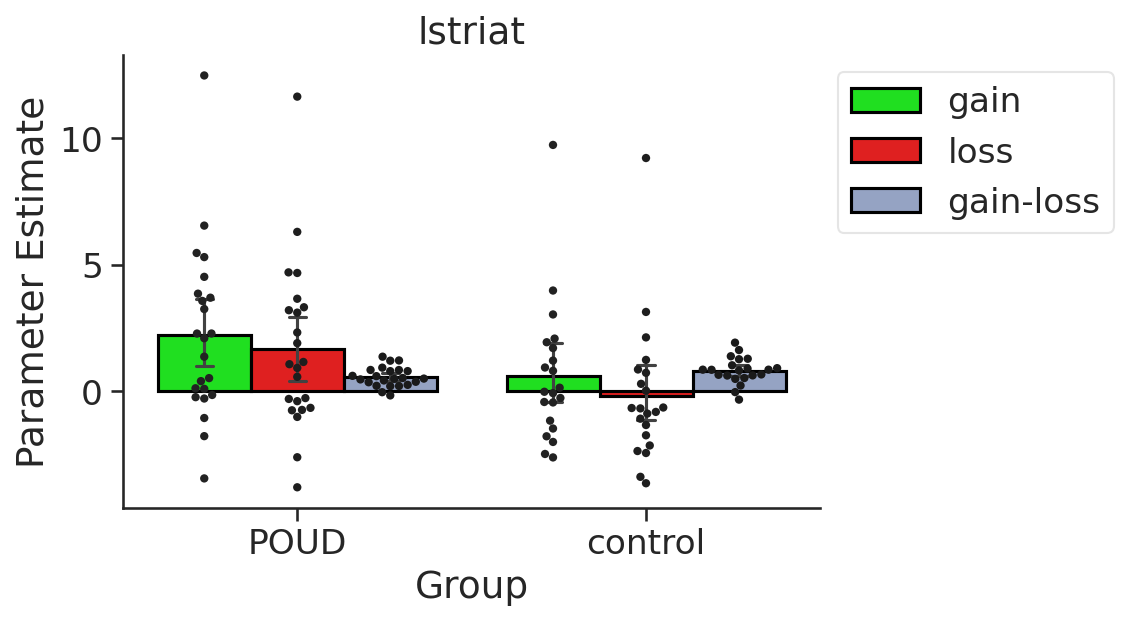

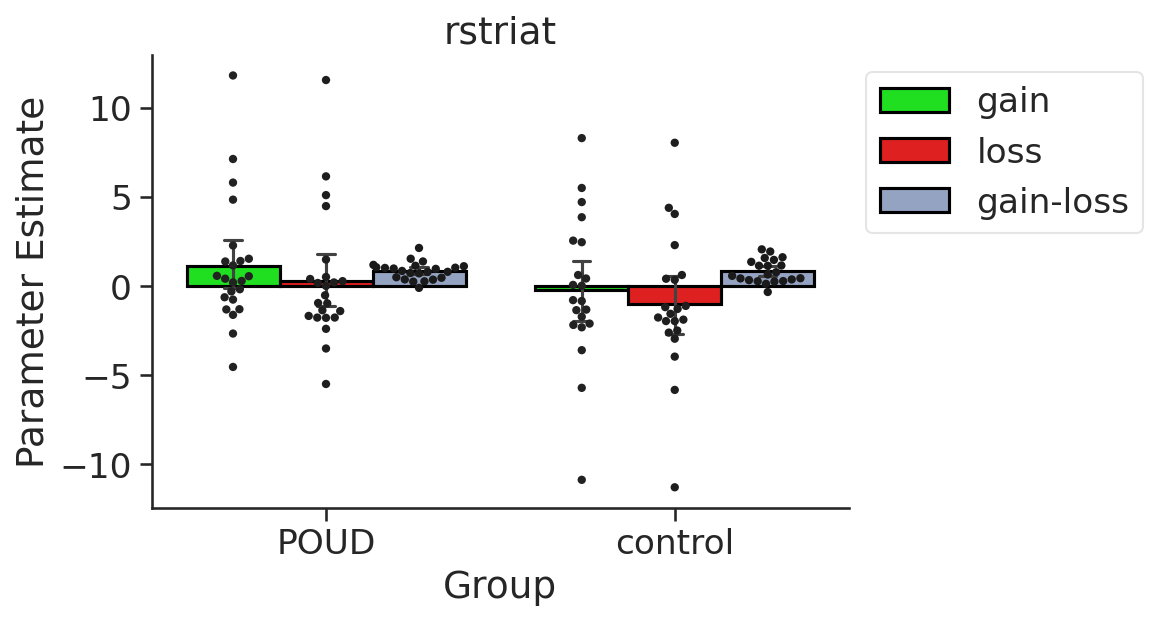

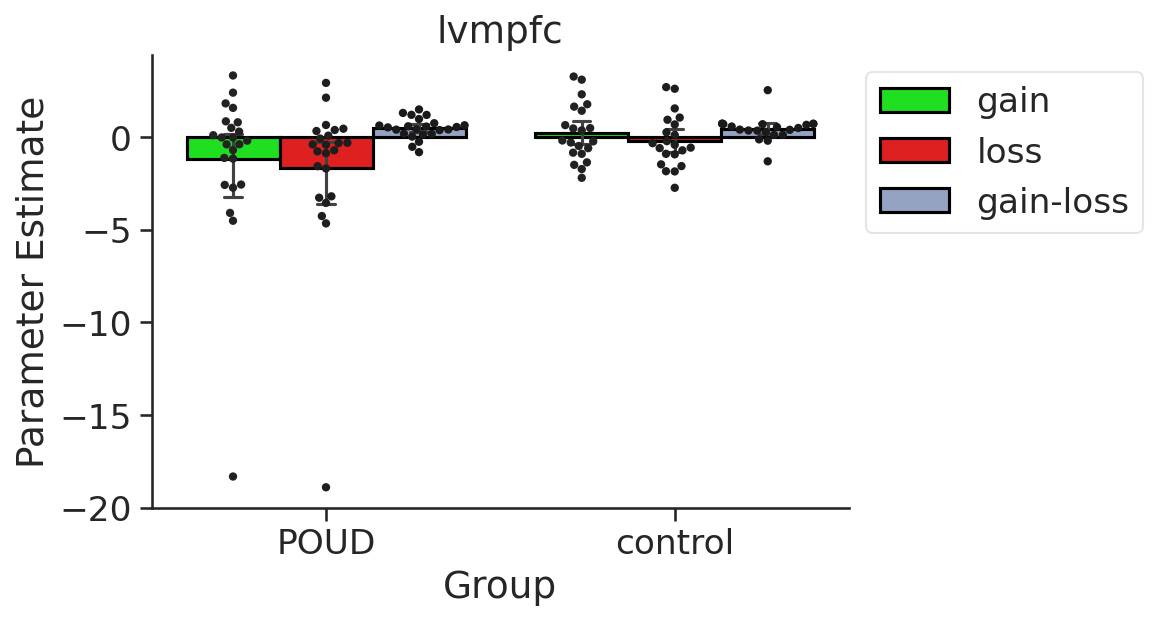

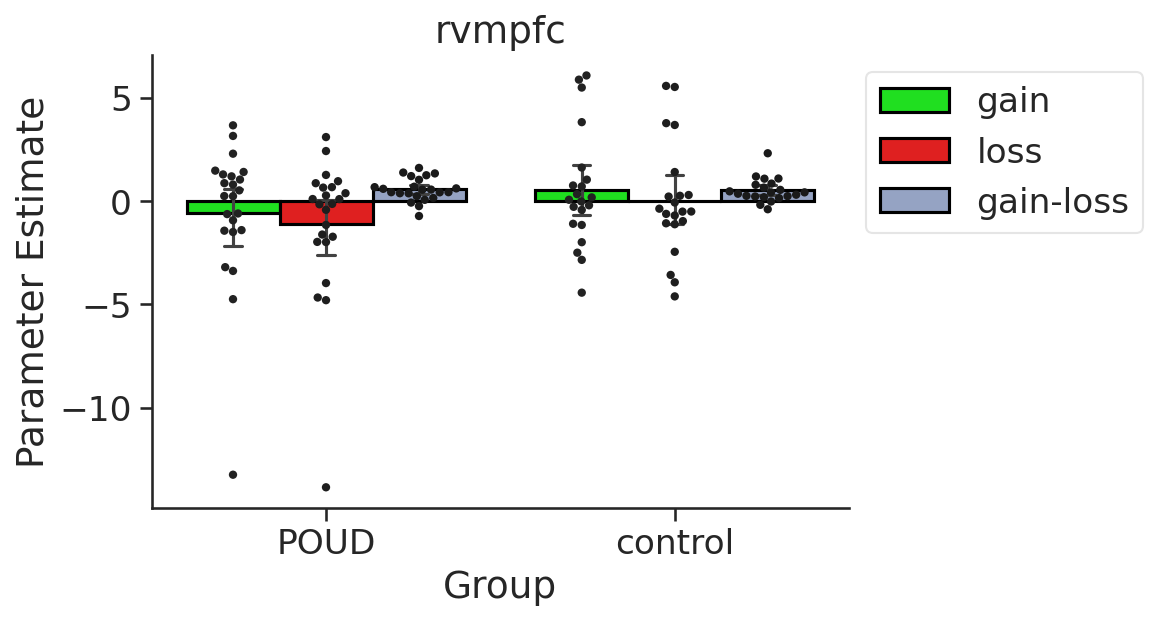

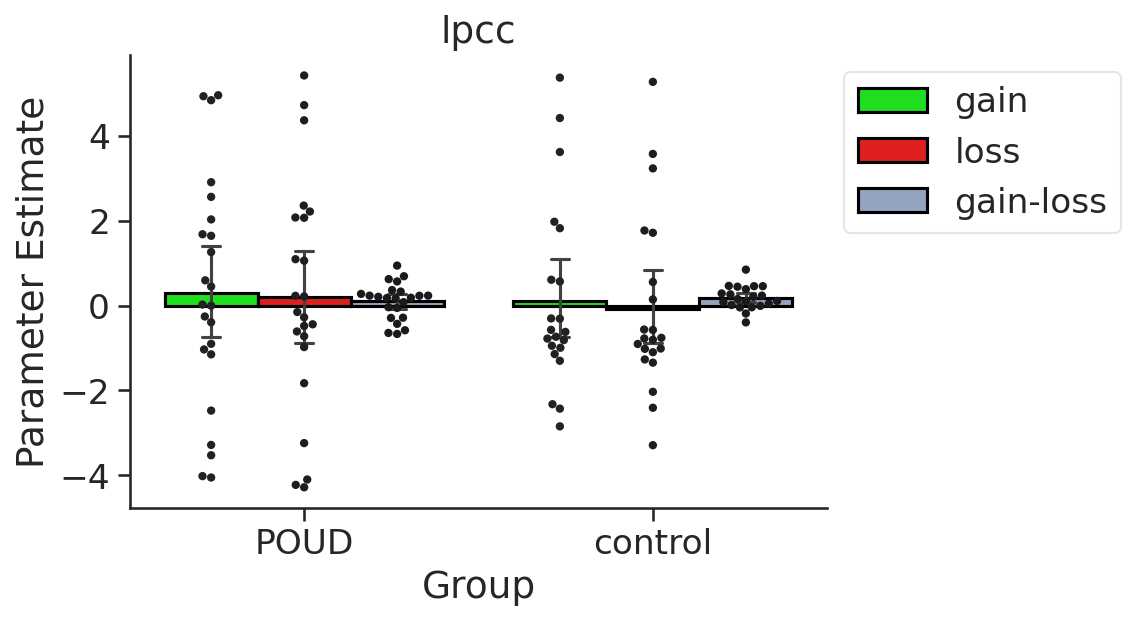

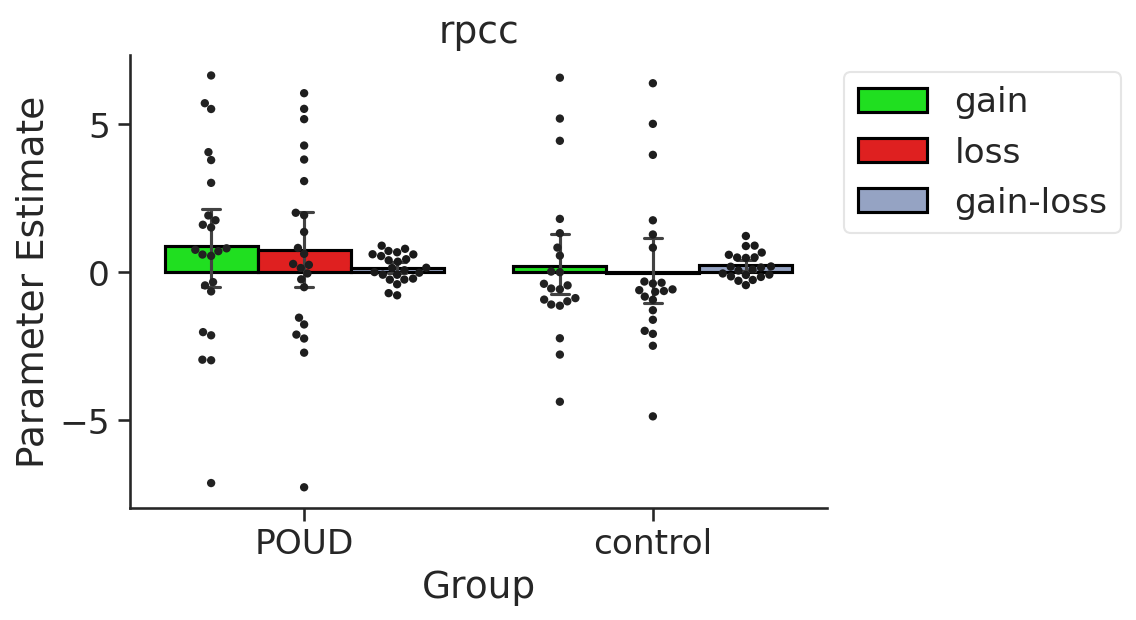

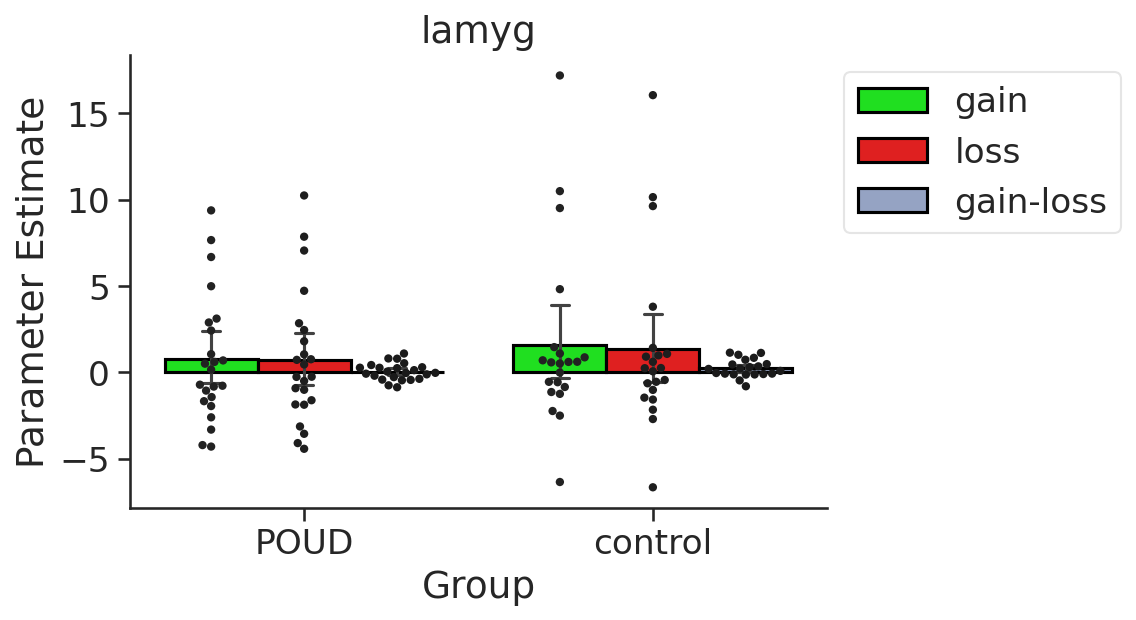

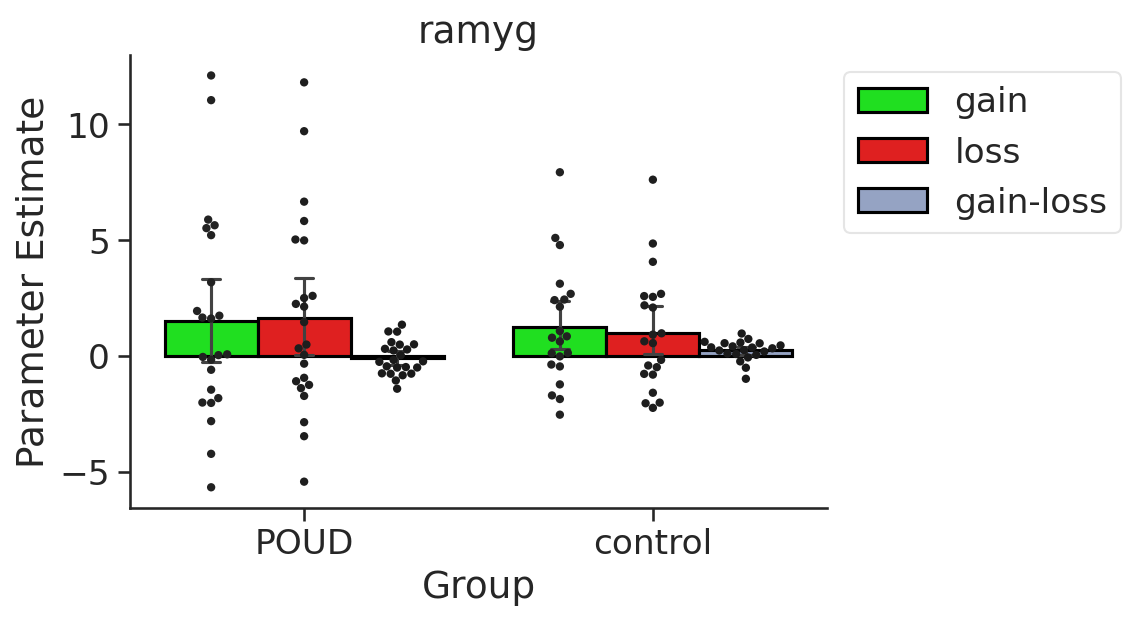

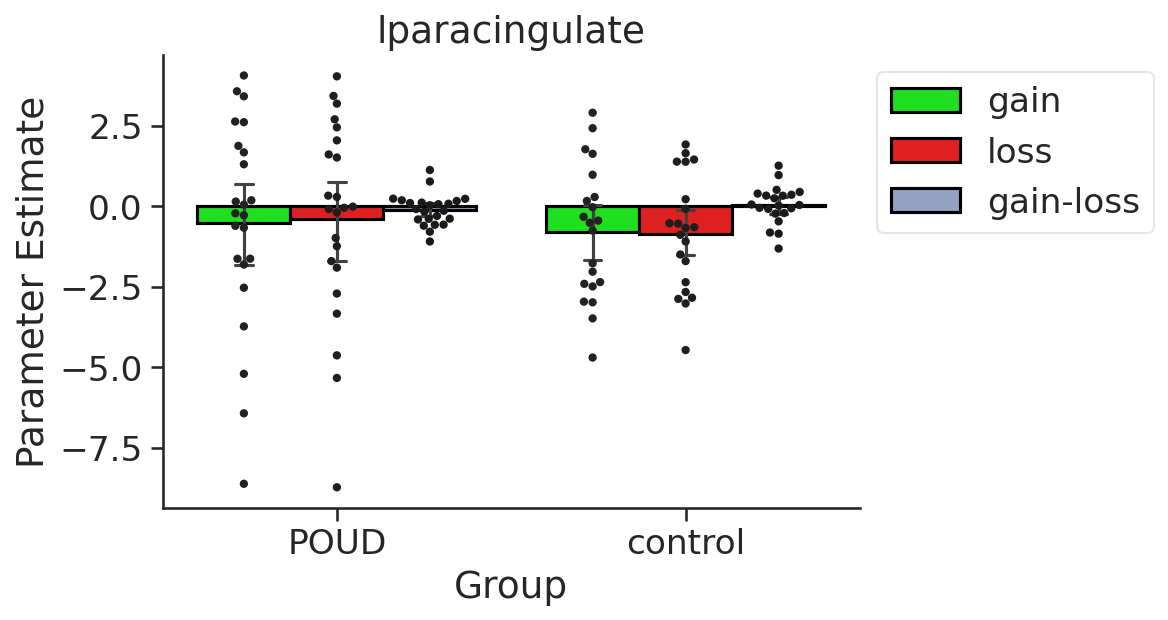

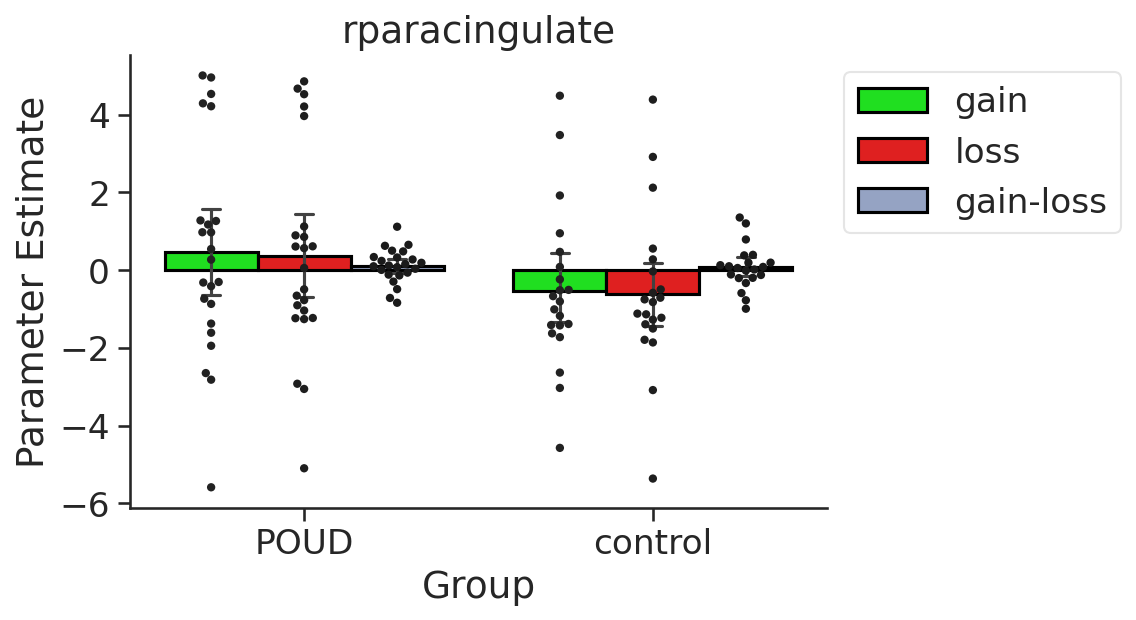

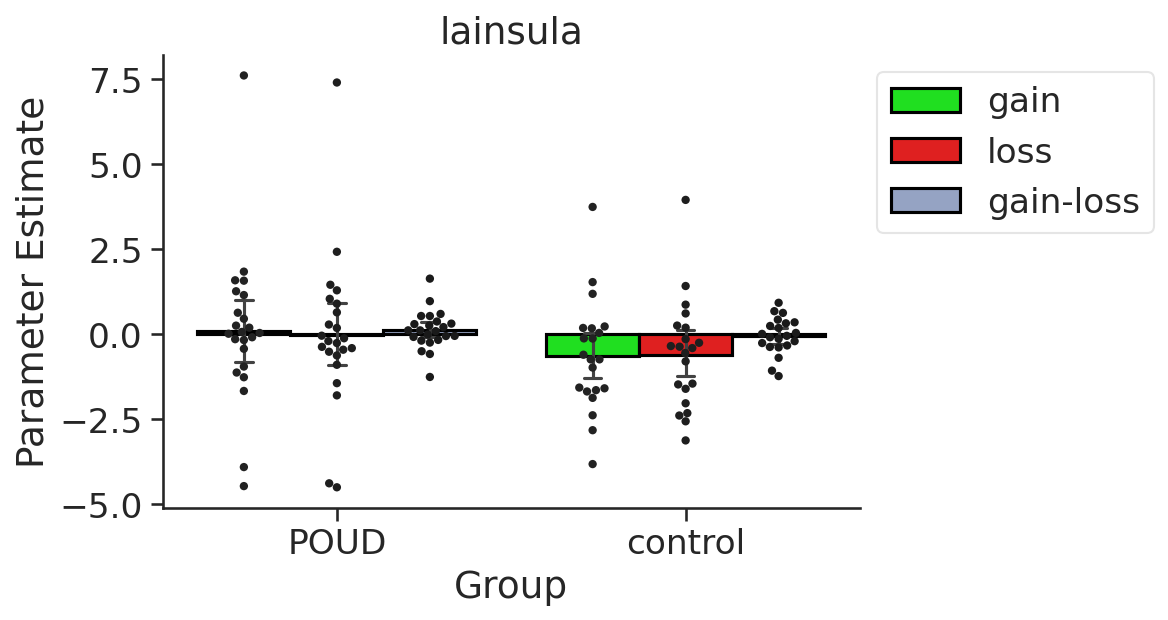

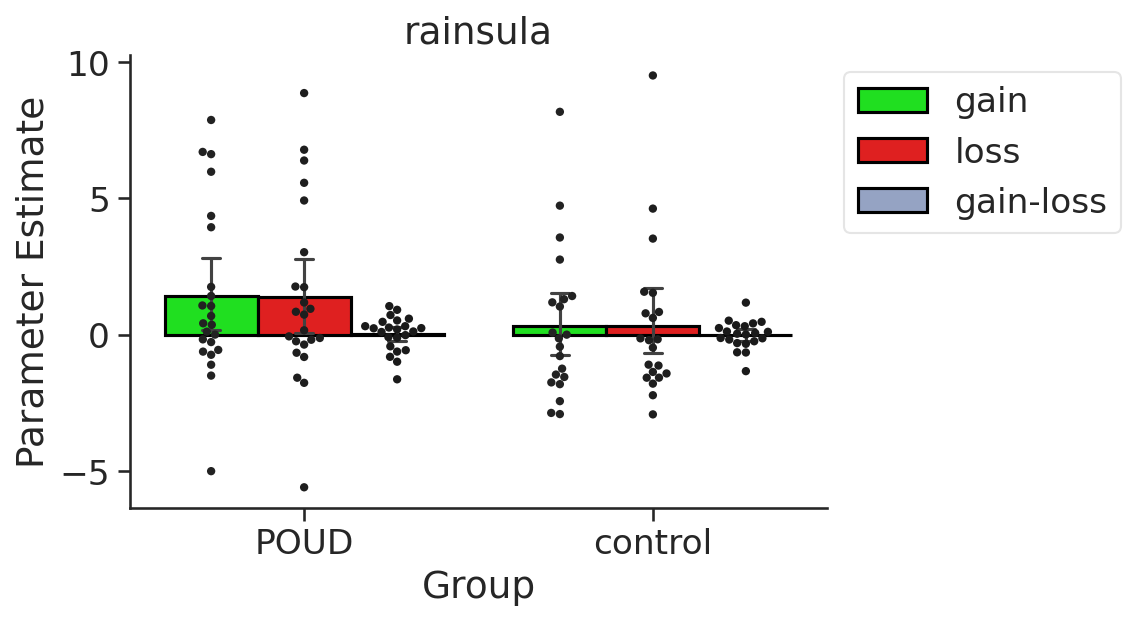

In [3]:
# Use this code for regular plotting with seaborn

show_conditions = ["gain","loss","gain-loss"] #which conditions to show in plots

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 150

###color and style preferences:
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")
sns.set_palette(["#00ff00","#ff0000","#8da0cb","#777777"]) #color codes from colorbrewer2.org
#re-read data
#alldata = pd.read_csv(estimates_output_file)
# scalefactor = .235
# alldata['estimate'] = alldata['estimate'] * scalefactor

#fig, axarr = plt.subplots(nrows=len(roi_list), ncols=1, sharey=True, sharex=False)
#fig.set_figwidth(12)
#fig.set_figheight(4*len(roi_list))
for idx_roi, roi in enumerate(roi_list): #plot one roi
    #ax = axarr[idx_roi]
    fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)
    ax.set_title(roi_labels[roi])
    roi_data = alldata.loc[(alldata['roi_name'] == roi) & 
                           (alldata['contrast'].isin(show_conditions)) & 
                           (alldata['subject'].isin(full_subject_list))]
    sns.barplot(x="group", y="estimate", hue="contrast", data=roi_data, ax=ax, 
                errwidth=1.5,capsize=.05, **{"edgecolor":"black", "linewidth":1.5})
    sns.swarmplot(x="group", y="estimate", hue="contrast", data=roi_data, ax=ax, size = 4,
                  dodge=True, color="k")
    ax.set_xlabel("Group")
    ax.set_ylabel("Parameter Estimate")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[len(show_conditions):], show_conditions, loc='upper left', bbox_to_anchor=(1, 1), 
              frameon=True, framealpha=.5)
    sns.despine(ax=ax)
    #fig.savefig("%s_GandL.jpg" % roi, bbox_inches="tight")


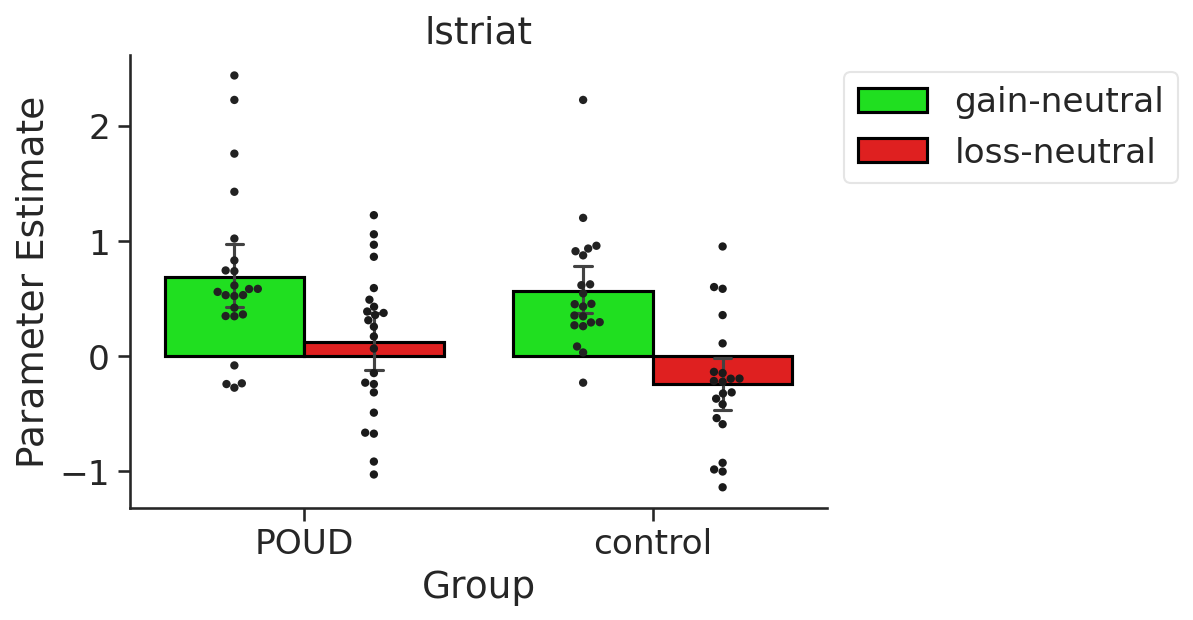

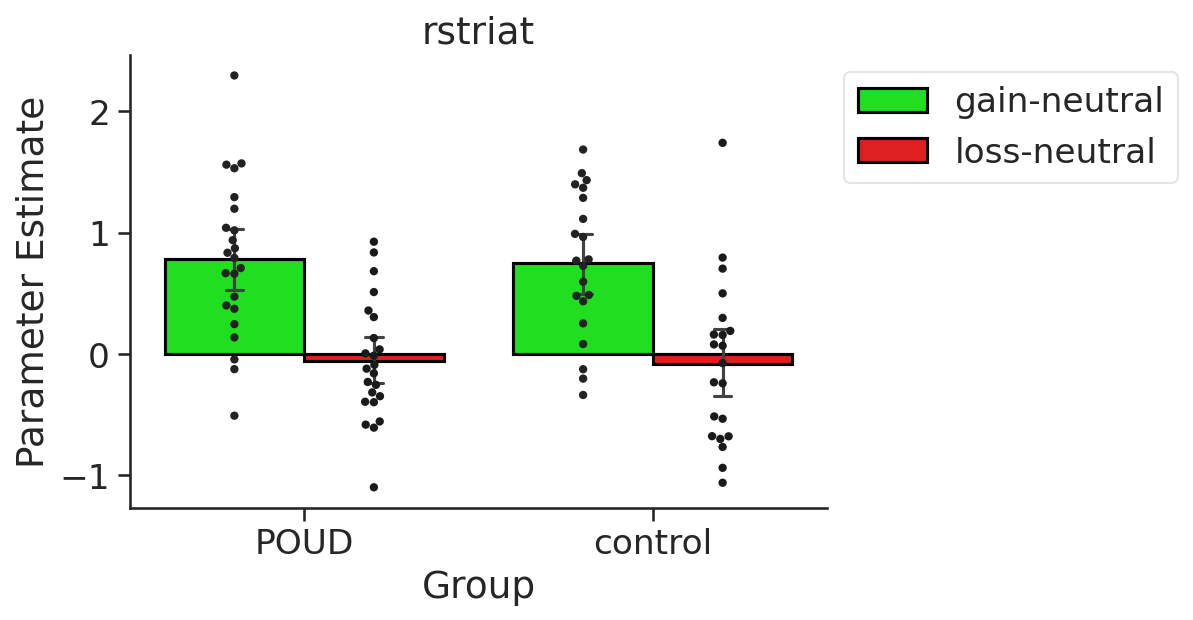

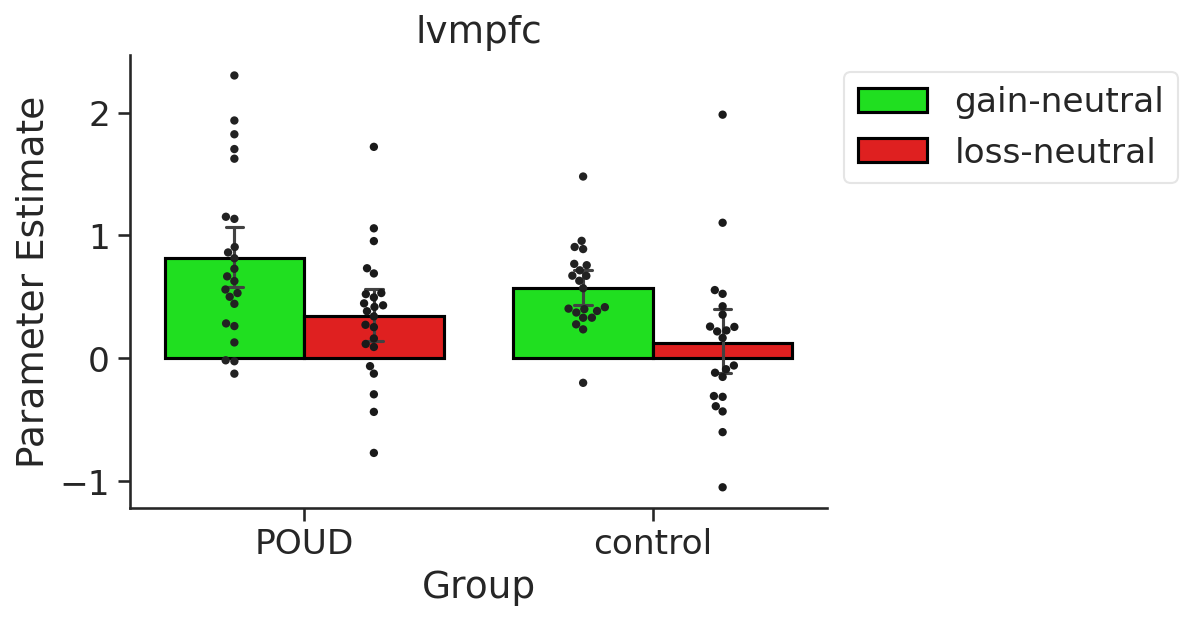

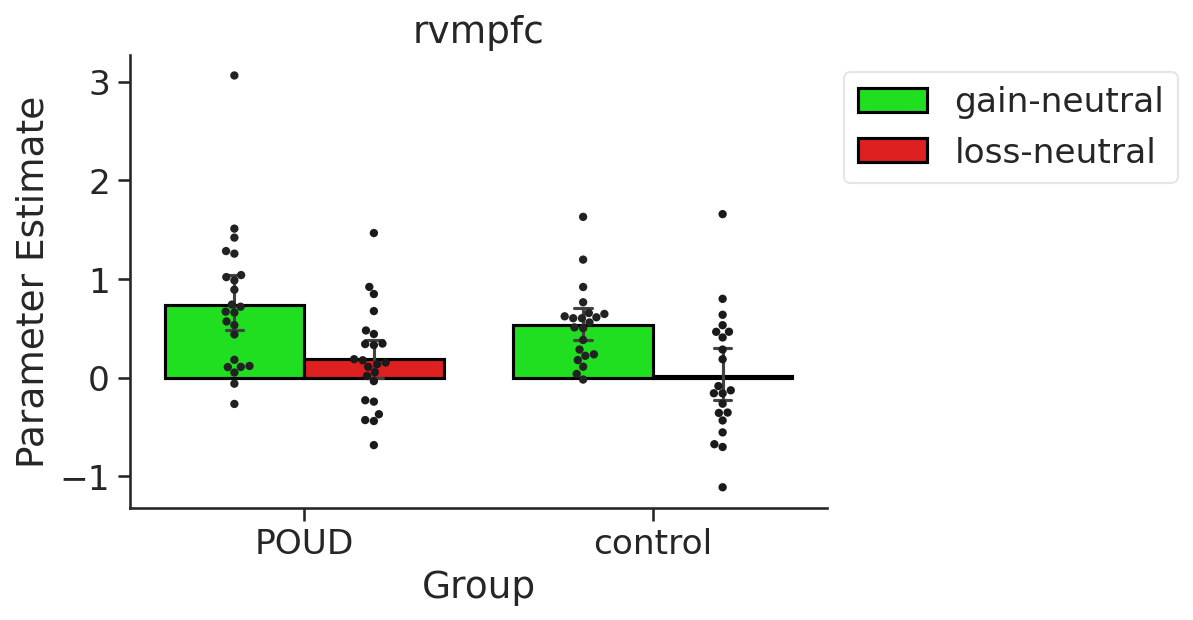

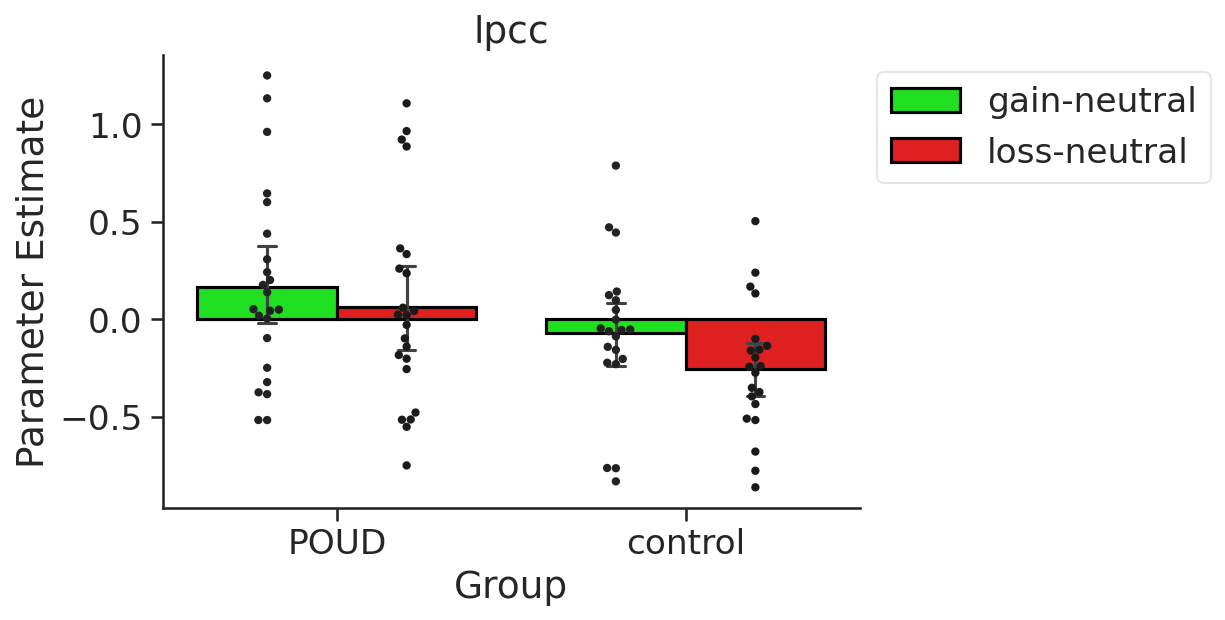

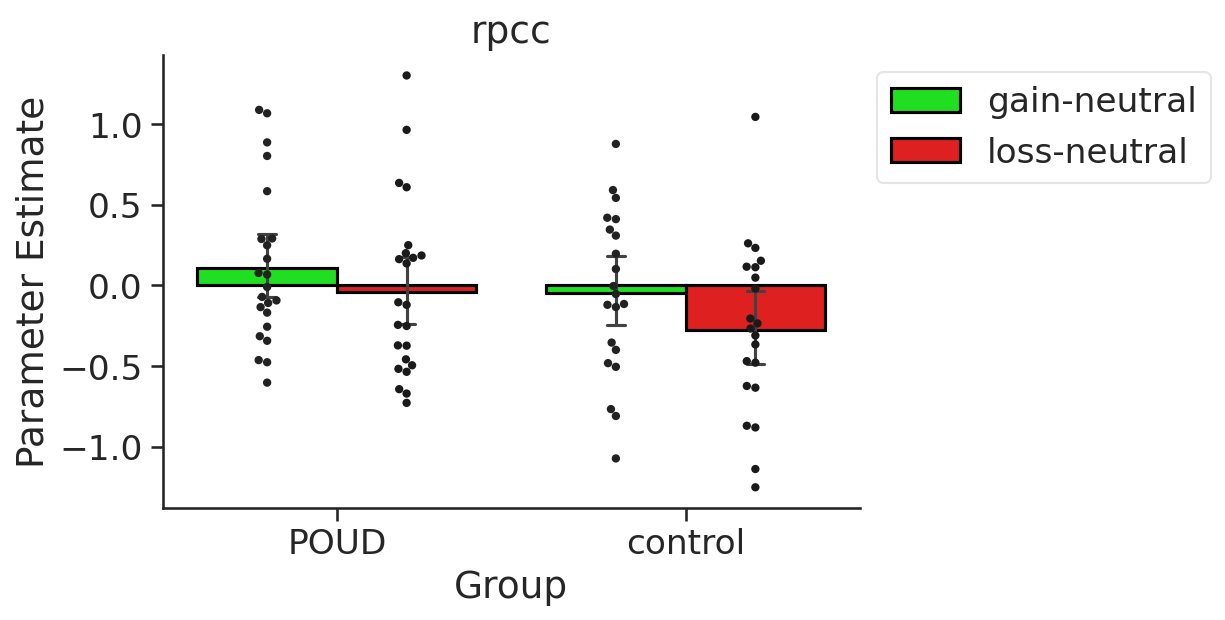

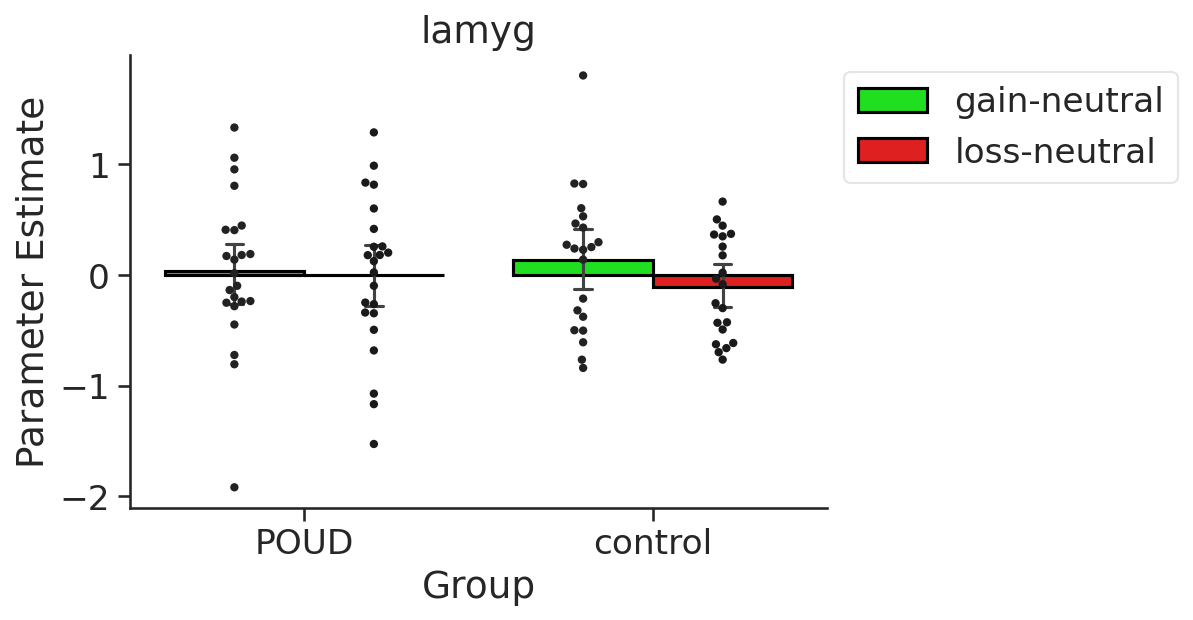

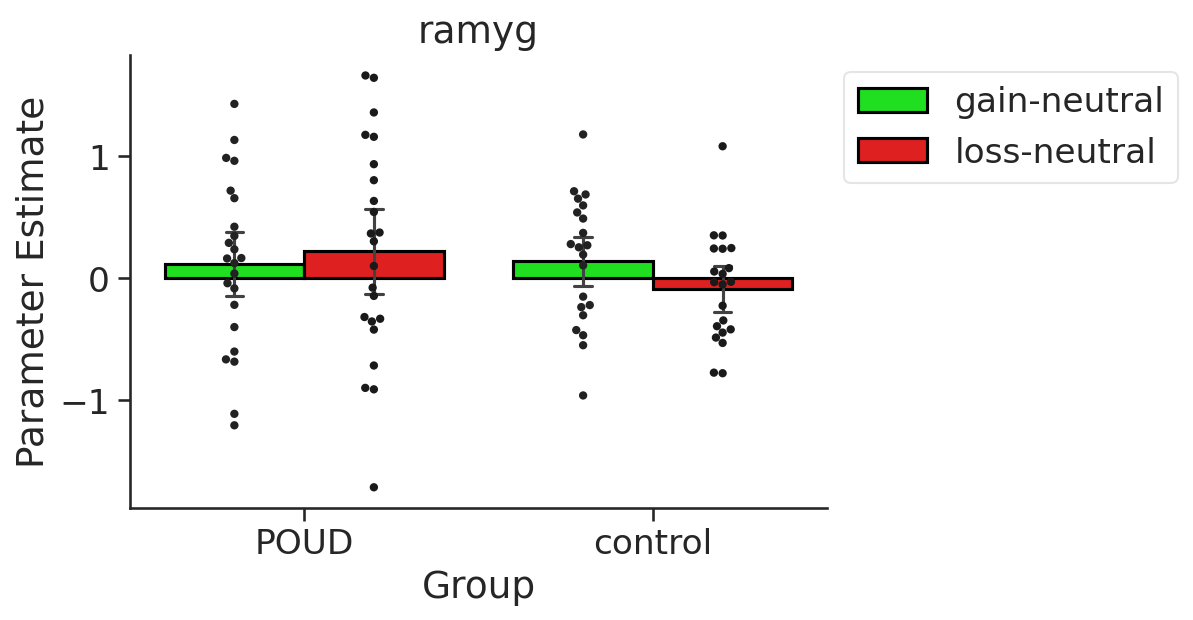

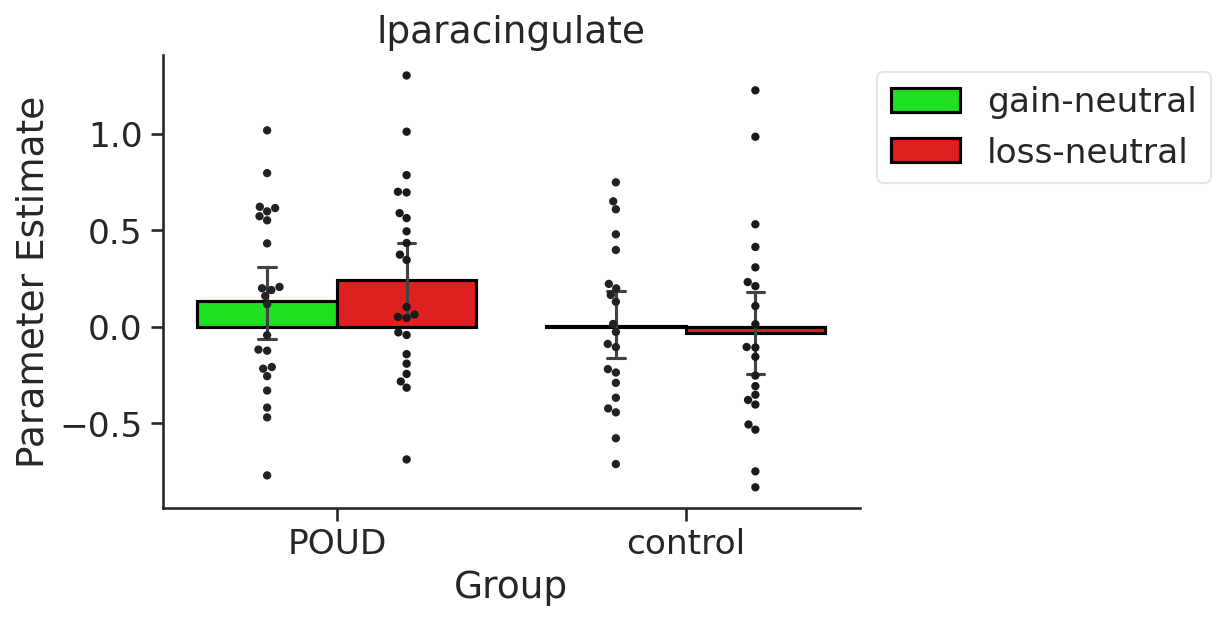

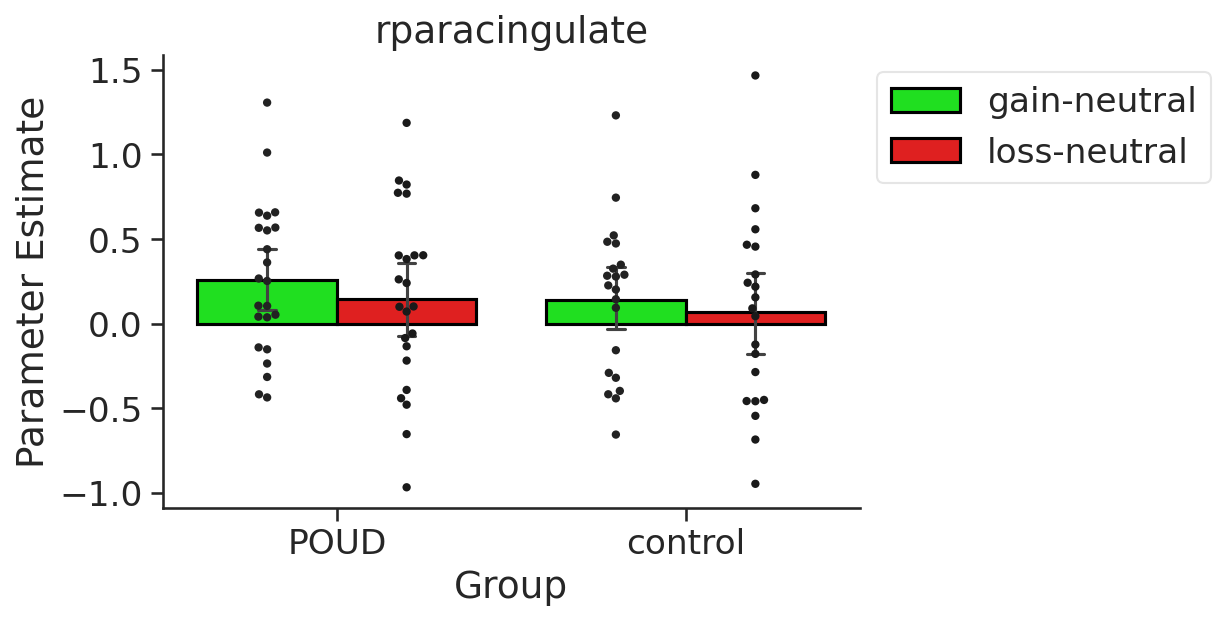

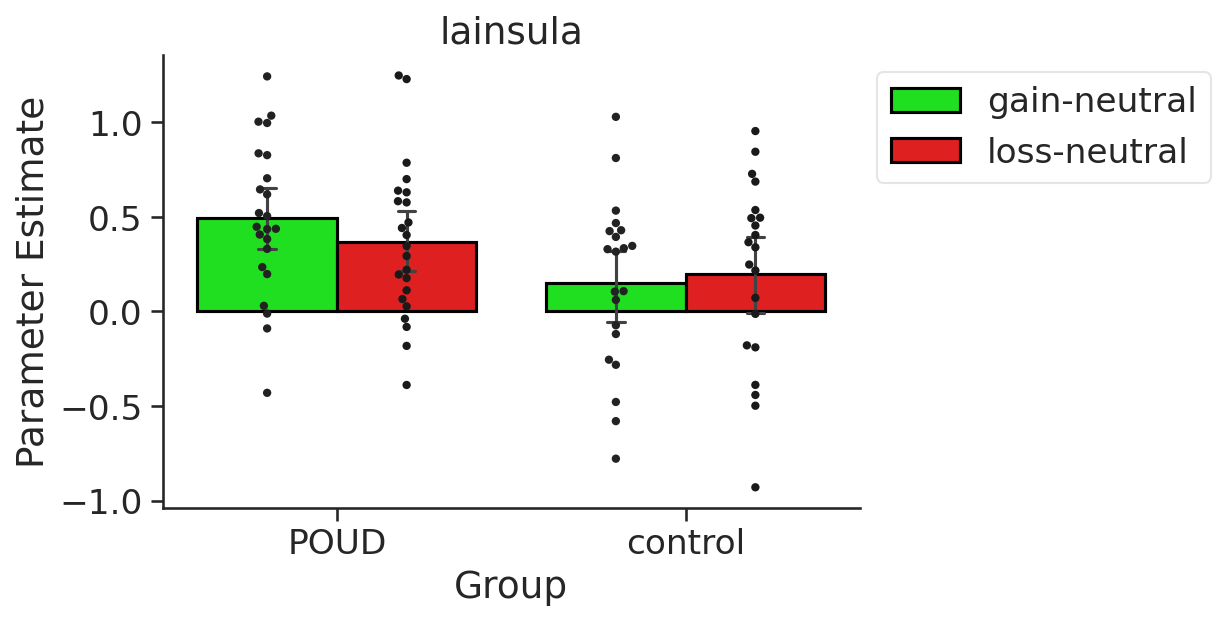

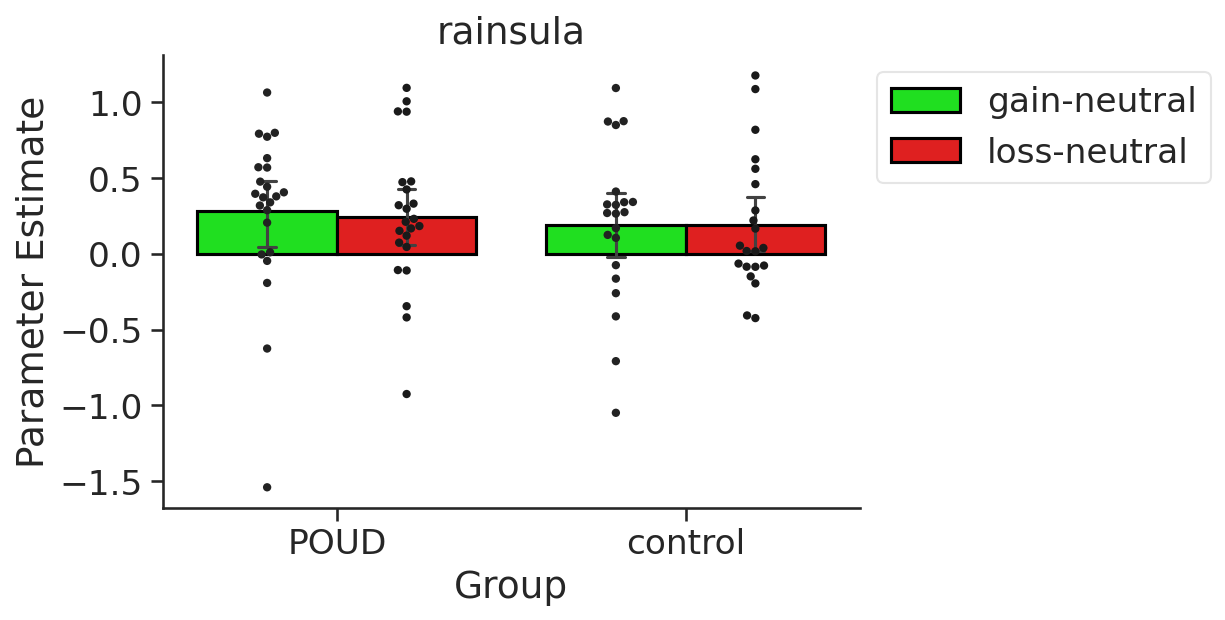

In [5]:
# Use this code for regular plotting with seaborn

show_conditions = ["gain-neutral","loss-neutral"] #which conditions to show in plots

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 150

###color and style preferences:
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")
sns.set_palette(["#00ff00","#ff0000","#8da0cb","#777777"]) #color codes from colorbrewer2.org
#re-read data
#alldata = pd.read_csv(estimates_output_file)
# scalefactor = .235
# alldata['estimate'] = alldata['estimate'] * scalefactor

#fig, axarr = plt.subplots(nrows=len(roi_list), ncols=1, sharey=True, sharex=False)
#fig.set_figwidth(12)
#fig.set_figheight(4*len(roi_list))
for idx_roi, roi in enumerate(roi_list): #plot one roi
    #ax = axarr[idx_roi]
    fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)
    ax.set_title(roi_labels[roi])
    roi_data = alldata.loc[(alldata['roi_name'] == roi) & 
                           (alldata['contrast'].isin(show_conditions)) & 
                           (alldata['subject'].isin(full_subject_list))]
    sns.barplot(x="group", y="estimate", hue="contrast", data=roi_data, ax=ax, 
                errwidth=1.5,capsize=.05, **{"edgecolor":"black", "linewidth":1.5})
    sns.swarmplot(x="group", y="estimate", hue="contrast", data=roi_data, ax=ax, size = 4,
                  dodge=True, color="k")
    ax.set_xlabel("Group")
    ax.set_ylabel("Parameter Estimate")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[len(show_conditions):], show_conditions, loc='upper left', bbox_to_anchor=(1, 1), 
              frameon=True, framealpha=.5)
    sns.despine(ax=ax)
    #fig.savefig('lstriat1.jpg')


## ROI stats


In [6]:
#t-tests on roi stuff
from scipy.stats import ttest_ind
from numpy import std, mean, sqrt
#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)


for roi in alldata.roi_name.unique():
    print("%s:" % roi)
    print("\tallEXP v CTL")
    for con in alldata.contrast.unique():
        t, p = ttest_ind( alldata.loc[((alldata['contrast']==con) & 
                                       (alldata['roi_name']==roi) &
                                       (alldata['group'].str.contains("POUD",regex=False))),'estimate'],
                          alldata.loc[((alldata['contrast']==con) & 
                                       (alldata['roi_name']==roi) &
                                       (alldata['group'].str.contains("control"))),'estimate']
                        )
        d = cohen_d( alldata.loc[((alldata['contrast']==con) & 
                                       (alldata['roi_name']==roi) &
                                       (alldata['group'].str.contains("POUD",regex=False))),'estimate'],
                          alldata.loc[((alldata['contrast']==con) & 
                                       (alldata['roi_name']==roi) &
                                       (alldata['group'].str.contains("control"))),'estimate']
                        )
        print("\t\t%s: t=%.4f, p=%.4f, d = %.3f" % (con,t,p,d))


BMK_fig9_l_striat:
	allEXP v CTL
		gain: t=1.7203, p=0.0927, d = 0.519
		loss: t=2.0178, p=0.0500, d = 0.609
		neutral: t=1.5456, p=0.1297, d = 0.466
		gain-loss: t=-1.8128, p=0.0770, d = -0.547
		gain-neutral: t=0.6212, p=0.5378, d = 0.188
		loss-neutral: t=2.0633, p=0.0453, d = 0.623
BMK_fig9_r_striat:
	allEXP v CTL
		gain: t=1.1719, p=0.2479, d = 0.354
		loss: t=1.1749, p=0.2466, d = 0.355
		neutral: t=1.1608, p=0.2523, d = 0.350
		gain-loss: t=0.0621, p=0.9508, d = 0.019
		gain-neutral: t=0.1783, p=0.8593, d = 0.054
		loss-neutral: t=0.1271, p=0.8995, d = 0.038
BMK_fig9_l_vmpfc:
	allEXP v CTL
		gain: t=-1.4648, p=0.1504, d = -0.442
		loss: t=-1.5028, p=0.1404, d = -0.454
		neutral: t=-1.6123, p=0.1144, d = -0.487
		gain-loss: t=0.1378, p=0.8911, d = 0.042
		gain-neutral: t=1.5213, p=0.1357, d = 0.459
		loss-neutral: t=1.2802, p=0.2075, d = 0.386
BMK_fig9_r_vmpfc:
	allEXP v CTL
		gain: t=-1.1430, p=0.2595, d = -0.345
		loss: t=-1.1938, p=0.2392, d = -0.360
		neutral: t=-1.3213, p=0.

In [7]:
# write in long/tidy format
alldata['roi_label'] = alldata['roi_name'].replace(roi_labels)
alldata.to_csv("../rois/preproc2_roi_estimates_tidy.csv")

In [8]:
# restructure to wide format
restructdata = alldata.loc[:,['subject','roi_label','contrast','estimate']].groupby(['subject','roi_label','contrast']).sum()
restructdata = restructdata.unstack().unstack()
restructdata.columns = pd.Index(["_".join(a) for a in restructdata.columns.to_flat_index() ]).str.replace("estimate_","")
# add group info
restructdata.reset_index(inplace=True)
restructdata['group'] = pd.cut(restructdata['subject'].astype(int),[0,700,900],labels=["POUD","CTL"])
# write wide format
restructdata.to_csv("../rois/preproc2_roi_estimates_wide.csv",index=False)

In [24]:
#look at cell history with _ih variable. useful if code is accidentally deleted
_ih[-9:]

['("%s/%s" % (feat_dir,featquery_outfile))',
 'os.path.isdir("%s/%s" % (feat_dir,featquery_outfile))',
 '# extract estimates and output to csv (stacked format, 1 row per estimate)\nalldata = pd.DataFrame(columns=["subject","group","roi_name","contrast","estimate"])\nfor igroup, group in enumerate(group_list):\n    for isub, subject in enumerate(subject_groups[group]):\n        for iroi, roi in enumerate(roi_list):\n            roi_file = "%s/%s.%s" %(roi_path,roi,nii_extension)\n            feat_stats_dir_stub = feat_stats_dir_format % subject\n            feat_stats_dir = "%s/%s" % (results_topdir,feat_stats_dir_stub)\n            feat_dir_stub = feat_dir_format % subject\n            feat_dir = "%s/%s" % (results_topdir,feat_dir_stub)\n            for icon, contrast in enumerate(contrast_list):\n                cope_id = contrast_ids[contrast]\n                fsmeants_outfile = "%s/ROI_%s_%s" % (feat_stats_dir,roi,cope_id)\n                featquery_outfile = "ROI_%s_%s" %(roi, cope